# Theft Data Analysis

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

In [3]:
#define source data_set urls
o_theft_url = "../data_sets/o_theft_clean.csv"
v_theft_url = "../data_sets/v_theft_clean.csv"

In [104]:
# Read Ottawa and Vancouver file and store into Pandas data frame
o_theft_df = pd.read_csv(o_theft_url)
v_theft_df = pd.read_csv(v_theft_url)
#o_theft_df

# Analysing Ottawa Data

In [62]:
#grouping data per year and month
o_theft_group = o_theft_df.groupby(['YEAR', 'MONTH']).count()
o_theft_group.reset_index(inplace=True)

#adding a x-axis marker for data series plots
o_theft_group["YEAR"] = o_theft_group["YEAR"].astype(str)
o_theft_group["MONTH"] = o_theft_group["MONTH"].astype(str)

#o_theft_group['x'] = o_theft_group["YEAR"]+"-"+o_theft_group["MONTH"]
o_theft_group['Marker'] = o_theft_group[["YEAR", "MONTH"]].agg("-".join,axis = 1)

o_theft_group


,YEAR,MONTH,Incident_StartDate,DAY,WEEKDAY,X,Y,LAT,LNG,Marker
0,2018,1,9,9,9,9,9,9,9,2018-1
1,2018,2,6,6,6,6,6,6,6,2018-2
2,2018,3,16,16,16,16,16,16,16,2018-3
3,2018,4,60,60,60,60,60,60,60,2018-4
4,2018,5,188,188,188,188,188,188,188,2018-5
5,2018,6,248,248,248,248,248,248,248,2018-6
6,2018,7,223,223,223,223,223,223,223,2018-7
7,2018,8,171,171,171,171,171,171,171,2018-8
8,2018,9,160,160,160,160,160,160,160,2018-9
9,2018,10,80,80,80,80,80,80,80,2018-10


In [124]:
o_theft_stat = o_theft_group.groupby(['YEAR']).agg({"Incident_StartDate": ['sum','mean','median','var','std','sem']})
o_theft_stat.reset_index(inplace=True)
o_theft_stat

YEAR Incident_StartDate                                             \
                       sum        mean median          var        std   
0  2018               1204  100.333333   70.0  8359.515152  91.430384   
1  2019               1175   97.916667   80.5  8321.719697  91.223460   
2  2020                962   80.166667   72.5  3327.242424  57.682254   

              
         sem  
0  26.393678  
1  26.333945  
2  16.651432

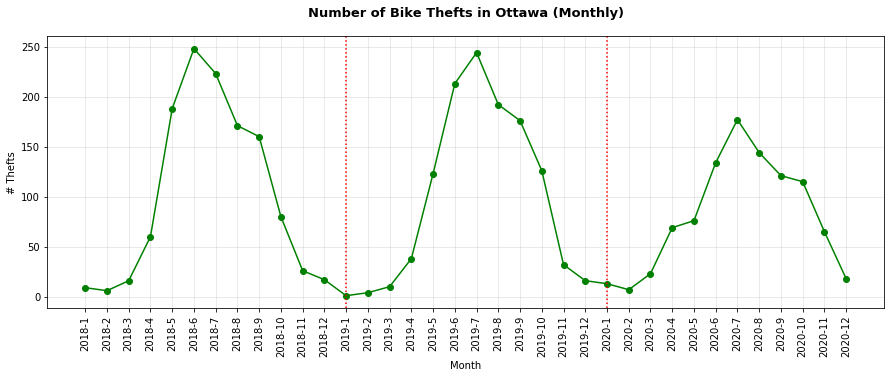

In [103]:
#ploting data series for Ottawa bike thefts (monthly)
plt.figure(figsize = (15,5))
plt.plot(o_theft_group["Marker"], o_theft_group["Incident_StartDate"],color = "g", marker = "o")

plt.title(f"Number of Bike Thefts in Ottawa (Monthly)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Month")
plt.xticks(rotation = 90)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.axvline(12, color = "red", linestyle = "dotted")
plt.axvline(24, color = "red", linestyle = "dotted")
plt.show()

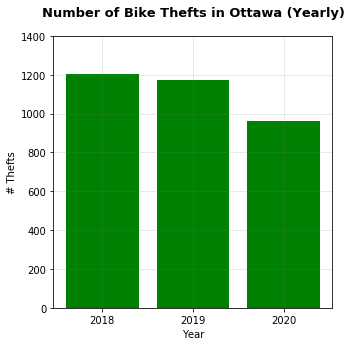

In [136]:
#ploting data series for Ottawa bike thefts (yearly)
plt.figure(figsize = (5,5))
plt.bar(o_theft_stat["YEAR"], o_theft_stat["Incident_StartDate"]["sum"],color = "g")

plt.title(f"Number of Bike Thefts in Ottawa (Yearly)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Year")
plt.xticks(rotation = 0)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.ylim(0,1400)
plt.show()


# Analysing Vancouver Data

In [105]:
#grouping data per year and month
v_theft_group = v_theft_df.groupby(['YEAR', 'MONTH']).count()
v_theft_group.reset_index(inplace=True)

#adding a x-axis marker for data series plots
v_theft_group["YEAR"] = v_theft_group["YEAR"].astype(str)
v_theft_group["MONTH"] = v_theft_group["MONTH"].astype(str)

#o_theft_group['x'] = o_theft_group["YEAR"]+"-"+o_theft_group["MONTH"]
v_theft_group['Marker'] = v_theft_group[["YEAR", "MONTH"]].agg("-".join,axis = 1)

v_theft_group

,YEAR,MONTH,Incident_Date,DAY,WEEKDAY,X,Y,LAT,LNG,Marker
0,2018,1,86,86,86,86,86,86,86,2018-1
1,2018,2,71,71,71,71,71,71,71,2018-2
2,2018,3,98,98,98,98,98,98,98,2018-3
3,2018,4,140,140,140,140,140,140,140,2018-4
4,2018,5,241,241,241,241,241,241,241,2018-5
5,2018,6,233,233,233,233,233,233,233,2018-6
6,2018,7,333,333,333,333,333,333,333,2018-7
7,2018,8,300,300,300,300,300,300,300,2018-8
8,2018,9,267,267,267,267,267,267,267,2018-9
9,2018,10,169,169,169,169,169,169,169,2018-10


In [139]:
v_theft_stat = v_theft_group.groupby(['YEAR']).agg({"Incident_Date": ['sum','mean','median','var','std','sem']})
v_theft_stat.reset_index(inplace=True)
v_theft_stat

YEAR Incident_Date                                                      
                  sum        mean median          var        std        sem
0  2018          2168  180.666667  154.5  8210.424242  90.611391  26.157256
1  2019          2219  184.916667  187.5  7969.356061  89.271250  25.770390
2  2020          1981  165.083333  159.5  4953.719697  70.382666  20.317726

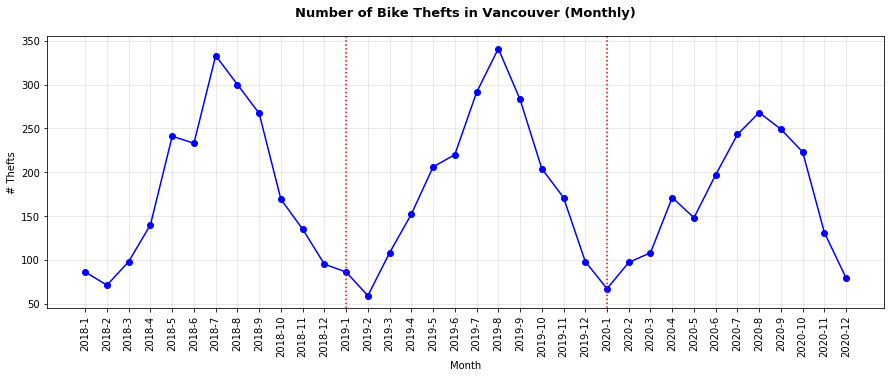

In [107]:
#ploting data series for Vancouver bike thefts
plt.figure(figsize = (15,5))
plt.plot(v_theft_group["Marker"], v_theft_group["Incident_Date"],color = "b", marker = "o")

plt.title(f"Number of Bike Thefts in Vancouver (Monthly)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Month")
plt.xticks(rotation = 90)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.axvline(12, color = "red", linestyle = "dotted")
plt.axvline(24, color = "red", linestyle = "dotted")
plt.show()

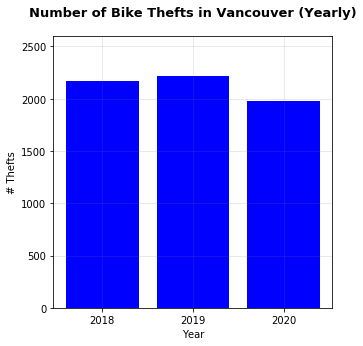

In [156]:
#ploting data series for Vancouver bike thefts (yearly)
plt.figure(figsize = (5,5))
plt.bar(v_theft_stat["YEAR"], v_theft_stat["Incident_Date"]["sum"],color = "b")

plt.title(f"Number of Bike Thefts in Vancouver (Yearly)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Year")
plt.xticks(rotation = 0)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.ylim(0,2600)
plt.show()



# Combined Analysis for two cities

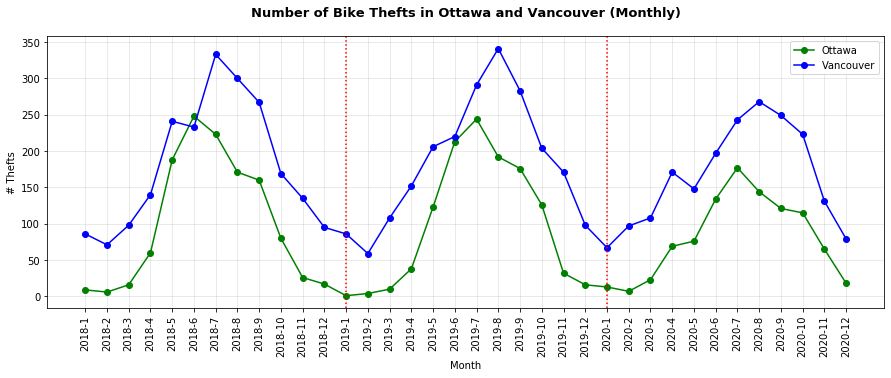

In [111]:
#ploting data series for bike thefts (monthly)
plt.figure(figsize = (15,5))
plt.plot(o_theft_group["Marker"], o_theft_group["Incident_StartDate"],color = "g", marker = "o", label = "Ottawa")
plt.plot(v_theft_group["Marker"], v_theft_group["Incident_Date"],color = "b", marker = "o", label = "Vancouver")

plt.title(f"Number of Bike Thefts in Ottawa and Vancouver (Monthly)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Month")
plt.xticks(rotation = 90)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.axvline(12, color = "red", linestyle = "dotted")
plt.axvline(24, color = "red", linestyle = "dotted")
plt.legend(loc = "best")
plt.show()

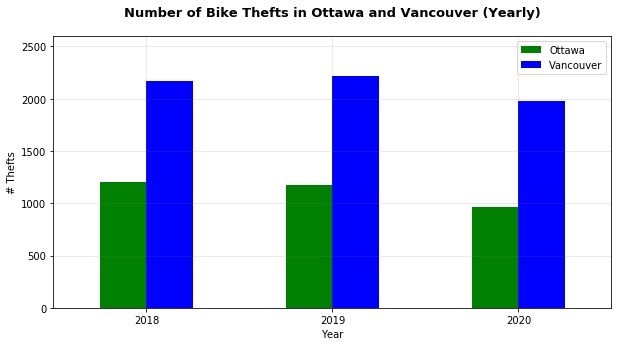

In [167]:
#ploting data series for bike thefts (yearly)
comb_df = pd.DataFrame(o_theft_stat["YEAR"])
comb_df["Ottawa"] = o_theft_stat["Incident_StartDate"]["sum"]
comb_df["Vancouver"] = v_theft_stat["Incident_Date"]["sum"]
multi_plot = comb_df.plot(kind = "bar", figsize = (10,5), color = ('g','b'))

multi_plot.set_xticklabels(comb_df["YEAR"])
plt.title(f"Number of Bike Thefts in Ottawa and Vancouver (Yearly)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Year")
plt.xticks(rotation = 0)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.ylim(0,2600)
plt.show()


need to do further anaysis of thefts per rides